## Monolingual Named Entity Recognition Token Classification (WikiNeural Dataset)

### BERT Base Cased Transformer

Dataset Source: https://huggingface.co/datasets/Babelscape/wikineural

#### Import Necessary Libraries

In [1]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import datasets
from datasets import load_dataset, DatasetDict

import torch
from torch import nn
from torch.nn.functional import cross_entropy

import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification
from transformers import Trainer, TrainingArguments

import evaluate

!git lfs install

Git LFS initialized.


#### Display Library Versions

In [2]:
print("Python :".rjust(18), sys.version[0:6])
print("NumPy :".rjust(18), np.__version__)
print("Torch :".rjust(18), torch.__version__)
print("Pandas :".rjust(18), pd.__version__)
print("Transformers :".rjust(18), transformers.__version__)
print("datasets :".rjust(18), datasets.__version__)
print("Sklearn :".rjust(18), sklearn.__version__)

          Python : 3.9.12
           NumPy : 1.24.3
           Torch : 2.0.0
          Pandas : 2.0.1
    Transformers : 4.28.1
        datasets : 2.11.0
         Sklearn : 1.2.2


#### Ingest English Subset of Dataset

In [3]:
data = load_dataset("Babelscape/wikineural")

data = data.remove_columns(["lang"])

data

Found cached dataset parquet (/Users/briandunn/.cache/huggingface/datasets/Babelscape___parquet/Babelscape--wikineural-579d1dc98d2a6b93/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/27 [00:00<?, ?it/s]

DatasetDict({
    train_es: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 76320
    })
    test_es: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 9618
    })
    test_de: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 12372
    })
    val_it: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 11050
    })
    train_en: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 92720
    })
    train_it: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 88400
    })
    train_nl: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 83680
    })
    train_pl: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 108160
    })
    test_pl: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 13585
    })
    val_ru: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 11540
    })
    test_nl: Dataset({


#### Split Dataset into DatasetDict

In [4]:
ds = DatasetDict({
    'train': data['train_en'], 
    'test': data['test_en'], 
    'eval': data['val_en']})

print('Training data shape:', ds['train'].shape)
print('Testing data shape:', ds['test'].shape)
print('Validation data shape:', ds['eval'].shape)

Training data shape: (92720, 2)
Testing data shape: (11597, 2)
Validation data shape: (11590, 2)


#### Example

In [5]:
example = ds['train'][12]

example

{'tokens': ['It',
  'has',
  'a',
  'leaf',
  'pattern',
  'similar',
  'to',
  'the',
  'members',
  'of',
  'the',
  'genera',
  '"',
  'Kedrostis',
  '"',
  ',',
  '"',
  'Melothria',
  '"',
  'and',
  '"',
  'Zehneria',
  '"',
  '.'],
 'ner_tags': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  7,
  0,
  0,
  0,
  7,
  0,
  0,
  0,
  7,
  0,
  0]}

#### Display Feature Information About Each Feature

In [6]:
for k, v in ds["train"].features.items():
    print(f"{k}: \n{v}\n")

tokens: 
Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)

ner_tags: 
Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)



#### Define Tag Values & Conversions Between String & Integer Values

In [25]:
label2id = {
    'O': 0, 
    'B-PER': 1, 
    'I-PER': 2, 
    'B-ORG': 3, 
    'I-ORG': 4, 
    'B-LOC': 5, 
    'I-LOC': 6, 
    'B-MISC': 7, 
    'I-MISC': 8
    }

id2label = {tag: idx for idx, tag in label2id.items()}

pos_tag_values = list(label2id.keys())
NUM_OF_LABELS = len(pos_tag_values)

print(f"List of tag values: \n{pos_tag_values}")
print(f"Number of NER Tags: \n{NUM_OF_LABELS}")
print(f"id2label: \n{id2label}")
print(f"label2id: \n{label2id}")

List of tag values: 
['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
Number of NER Tags: 
9
id2label: 
{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}
label2id: 
{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}


#### Basic Values/Constants

In [8]:
MODEL_CKPT = "bert-base-cased"
MODEL_NAME = f"{MODEL_CKPT.split(f'/')[-1]}-finetuned-WikiNeural"

NUM_OF_EPOCHS = 2
BATCH_SIZE = 16

STRATEGY = "epoch"
REPORTS_TO = "tensorboard"

WEIGHT_DECAY = 0.01
LR = 2e-5

DEVICE = torch.device("cpu")
STEPS = 1250

#### Function to Tokenize & Align Inputs

In [9]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize_and_align_labels(samples):
    tokenized_inputs = tokenizer(samples["tokens"], 
                                      truncation=True, 
                                      is_split_into_words=True)
    
    labels = []
    
    for idx, label in enumerate(samples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        prev_word_idx = None
        label_ids = []
        for word_idx in word_ids: # set special tokens to -100
            if word_idx is None or word_idx == prev_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            prev_word_idx = word_idx
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

#### Apply Above Function to Tokenize Dataset

In [10]:
encoded_ds = ds.map(tokenize_and_align_labels, 
                    batched=True, 
                    remove_columns=
                        [
                            'ner_tags', 
                            'tokens'
                        ]
                    )

Loading cached processed dataset at /Users/briandunn/.cache/huggingface/datasets/Babelscape___parquet/Babelscape--wikineural-579d1dc98d2a6b93/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-5017e8265a954f19.arrow


Map:   0%|          | 0/11597 [00:00<?, ? examples/s]

Loading cached processed dataset at /Users/briandunn/.cache/huggingface/datasets/Babelscape___parquet/Babelscape--wikineural-579d1dc98d2a6b93/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-2df3e82508a9f790.arrow


#### Define Data Collator

In [11]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

#### Load Custom Model

In [12]:
model = (AutoModelForTokenClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=NUM_OF_LABELS,
    id2label=id2label,
    label2id=label2id
    ).to(DEVICE))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

#### Create Compute Metrics Function

In [13]:
label_list = pos_tag_values

seqeval = evaluate.load("seqeval")

labels = [label_list[i] for i in example[f'ner_tags']]

def compute_metrics(eval_preds):
    predictions, labels = eval_preds
    predictions = np.argmax(predictions, 
                            axis=2)
    
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    results = seqeval.compute(predictions=true_predictions, 
                              references=true_labels)
    
    return results

#### Define TrainingArguments

In [14]:
args = TrainingArguments(
    MODEL_NAME,
    log_level="error",
    logging_first_step=True,
    learning_rate=LR,
    num_train_epochs=NUM_OF_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy=STRATEGY,
    report_to=REPORTS_TO,
    disable_tqdm=False,
    logging_steps=STEPS,
    weight_decay=WEIGHT_DECAY,
    save_strategy=STRATEGY,
    hub_private_repo=True,
    push_to_hub=True
)

#### Subclass Trainer to Handle Class Imbalance

In [15]:
class CustomTrainer(Trainer):
    def compute_loss(self, 
                     model, 
                     inputs, 
                     return_outputs=False):
        
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss 
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(
            [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0], 
            device=model.device)
        )
        loss = loss_fct(logits.view(-1, 
                                    self.model.config.num_labels), 
                        labels.view(-1)
                        )
        return (loss, outputs) if return_outputs else loss

#### Define Trainer

In [16]:
trainer = CustomTrainer(model, 
                  args=args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  tokenizer=tokenizer,
                  train_dataset=encoded_ds["train"],
                  eval_dataset=encoded_ds["test"]
                  )

Cloning https://huggingface.co/DunnBC22/bert-base-cased-finetuned-WikiNeural into local empty directory.


#### Train Model

In [17]:
train_results = trainer.train()

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/11590 [00:00<?, ?it/s]

{'loss': 2.1548, 'learning_rate': 1.9998274374460744e-05, 'epoch': 0.0}
{'loss': 0.2062, 'learning_rate': 1.7842968075927526e-05, 'epoch': 0.22}
{'loss': 0.1157, 'learning_rate': 1.5685936151855047e-05, 'epoch': 0.43}
{'loss': 0.1036, 'learning_rate': 1.3528904227782573e-05, 'epoch': 0.65}
{'loss': 0.1, 'learning_rate': 1.1371872303710096e-05, 'epoch': 0.86}


  0%|          | 0/725 [00:00<?, ?it/s]

{'eval_loss': 0.09429672360420227, 'eval_LOC': {'precision': 0.9075480846937126, 'recall': 0.9429051217464316, 'f1': 0.9248888156811068, 'number': 5955}, 'eval_MISC': {'precision': 0.8320190720704199, 'recall': 0.8964631495751828, 'f1': 0.8630397565151225, 'number': 5061}, 'eval_ORG': {'precision': 0.9151428571428571, 'recall': 0.9286749782545666, 'f1': 0.9218592603252267, 'number': 3449}, 'eval_PER': {'precision': 0.9683036587751908, 'recall': 0.9499040307101727, 'f1': 0.9590155992636372, 'number': 5210}, 'eval_overall_precision': 0.9038565996740902, 'eval_overall_recall': 0.9303176620076239, 'eval_overall_f1': 0.9168962580774432, 'eval_overall_accuracy': 0.9901143530909022, 'eval_runtime': 867.3781, 'eval_samples_per_second': 13.37, 'eval_steps_per_second': 0.836, 'epoch': 1.0}
{'loss': 0.0827, 'learning_rate': 9.214840379637619e-06, 'epoch': 1.08}
{'loss': 0.061, 'learning_rate': 7.057808455565142e-06, 'epoch': 1.29}
{'loss': 0.0587, 'learning_rate': 4.900776531492667e-06, 'epoch': 

  0%|          | 0/725 [00:00<?, ?it/s]

{'eval_loss': 0.0880606546998024, 'eval_LOC': {'precision': 0.9282034236330398, 'recall': 0.9378673383711167, 'f1': 0.9330103575008353, 'number': 5955}, 'eval_MISC': {'precision': 0.8336608897623727, 'recall': 0.9219521833629718, 'f1': 0.8755864139613436, 'number': 5061}, 'eval_ORG': {'precision': 0.9351851851851852, 'recall': 0.9370832125253696, 'f1': 0.9361332367849385, 'number': 3449}, 'eval_PER': {'precision': 0.9728037566034045, 'recall': 0.9543186180422265, 'f1': 0.9634725317314214, 'number': 5210}, 'eval_overall_precision': 0.914474010207621, 'eval_overall_recall': 0.9379923761118171, 'eval_overall_f1': 0.9260839020473706, 'eval_overall_accuracy': 0.9911586906477513, 'eval_runtime': 865.1849, 'eval_samples_per_second': 13.404, 'eval_steps_per_second': 0.838, 'epoch': 2.0}
{'train_runtime': 46397.543, 'train_samples_per_second': 3.997, 'train_steps_per_second': 0.25, 'train_loss': 0.09300354592649972, 'epoch': 2.0}


#### Push Model To Hub

In [18]:
kwargs = {
    "tasks": "token-classification",
    "tags": ['token-classification'],
}

if args.push_to_hub:
    trainer.push_to_hub('All DUNN!!!', **kwargs)
else:
    trainer.create_model_card(**kwargs)

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/411M [00:00<?, ?B/s]

Upload file runs/Jul09_20-29-49_Brians-Mac-mini/events.out.tfevents.1688952594.Brians-Mac-mini.7897.0:   0%|  …

To https://huggingface.co/DunnBC22/bert-base-cased-finetuned-WikiNeural
   321e00a..c81e524  main -> main

To https://huggingface.co/DunnBC22/bert-base-cased-finetuned-WikiNeural
   c81e524..3aaf5cc  main -> main



#### Save & Log Model

In [19]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

To https://huggingface.co/DunnBC22/bert-base-cased-finetuned-WikiNeural
   3aaf5cc..5252ebe  main -> main



***** train metrics *****
  epoch                    =         2.0
  train_loss               =       0.093
  train_runtime            = 12:53:17.54
  train_samples_per_second =       3.997
  train_steps_per_second   =        0.25


### Error Analysis

#### Define Method to Apply to Validation Dataset (& Then Apply it)

In [35]:
def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(DEVICE)
    attention_mask = batch["attention_mask"].to(DEVICE)
    labels = batch["labels"].to(DEVICE)
    with torch.no_grad():
        # Pass data through model  
        output = trainer.model(input_ids, 
                               attention_mask
                               )
        # Logit.size: [batch_size, sequence_length, classes]
        predicted_label = torch.argmax(output.logits, 
                                       axis=-1
                                       ).cpu().numpy()
        
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 9), 
                         labels.view(-1), 
                         reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

#### Apply Above Function to Entire Evaluation Dataset

In [36]:
eval_set = encoded_ds['eval']

eval_set = eval_set.map(forward_pass_with_label,
                        batched=True,
                        batch_size=32)

eval_df = eval_set.to_pandas()

Map:   0%|          | 0/11590 [00:00<?, ? examples/s]

#### Clean Up Padding Tokens

In [37]:
id2label[-100] = "IGN"
eval_df["input_tokens"] = eval_df["input_ids"].apply(
    lambda x: tokenizer.convert_ids_to_tokens(x))
eval_df["predicted_label"] = eval_df["predicted_label"].apply(
    lambda x: [id2label[i] for i in x])
eval_df["labels"] = eval_df["labels"].apply(
    lambda x: [id2label[i] for i in x])
eval_df['loss'] = eval_df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
eval_df['predicted_label'] = eval_df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
eval_df.head(1)

,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[101, 1430, 3143, 1106, 17037, 7501, 1358, 110...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, O, O, B-LOC, IGN, IGN, O, O, O, O, O,...","[0.0, 1.9430925e-05, 2.3483954e-05, 3.7192607e...","[O, O, O, O, B-LOC, I-LOC, I-LOC, O, O, O, O, ...","[[CLS], Her, visit, to, Tu, ##val, ##u, was, c..."


#### Unwrap Each Token Within Sample Separately

In [38]:
eval_df_tokens = eval_df.apply(pd.Series.explode)
eval_df_tokens = eval_df_tokens.query("labels != 'IGN'")
eval_df_tokens["loss"] = eval_df_tokens["loss"].astype(float).round(2)
eval_df_tokens.head(7)

,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,1430,0,1,O,0.0,O,Her
0,3143,0,1,O,0.0,O,visit
0,1106,0,1,O,0.0,O,to
0,17037,0,1,B-LOC,0.0,B-LOC,Tu
0,1108,0,1,O,0.0,O,was
0,2195,0,1,O,0.0,O,cut
0,1603,0,1,O,0.0,O,short


#### See Which Tokens Have Accumulated Most Loss in Evaluation Dataset

In [39]:
(
    eval_df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(3)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,Batman,The,–,B,E,of,P,A,W,Mi
count,104,2487,486,242,202,7358,200,544,144,70
mean,2.543,0.05,0.228,0.437,0.452,0.012,0.437,0.15,0.48,0.907
sum,264.47,124.88,110.98,105.66,91.37,87.44,87.31,81.53,69.17,63.51


#### See Which Label IDs Have Most Loss in Evaluation Dataset

In [40]:
(
    eval_df_tokens.groupby("labels")[["loss"]] 
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(3)
    .fillna(0)
    .T
)

,0,1,2,3,4,5,6,7,8
labels,I-MISC,B-ORG,B-MISC,B-PER,I-LOC,B-LOC,I-ORG,I-PER,O
count,4555,3512,4173,5593,2370,5904,2963,4107,234662
mean,0.281,0.256,0.248,0.189,0.176,0.153,0.136,0.026,0.011
sum,1278.88,900.28,1035.12,1055.01,417.27,903.81,402.82,107.87,2508.58


#### Create Function to Display Confusion Matrix

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized Confusion Matrix")
    plt.show()

#### Display Confusion Matrix

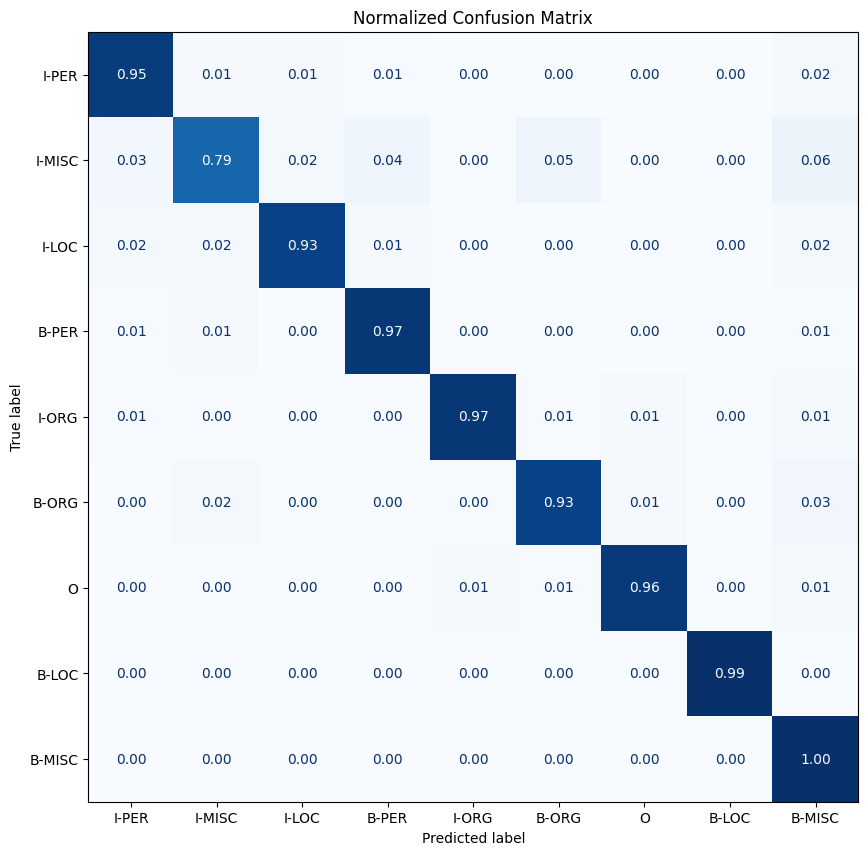

In [42]:
eval_token_list = list(set(eval_df_tokens['labels']))

plot_confusion_matrix(eval_df_tokens["labels"], eval_df_tokens["predicted_label"],
                      eval_token_list)

#### Define & Call Function to Display Example Token Sequences Along With Labels & Losses

In [43]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        eval_df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels, 
                               "preds": preds, "losses": losses}).T
        yield eval_df_tmp

eval_df["total_loss"] = eval_df["loss"].apply(sum)
eval_df_tmp = eval_df.sort_values(by="total_loss", ascending=False).head(3)

pd.set_option('display.max_columns', None)

for sample in get_samples(eval_df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
tokens,He,was,selected,to,go,on,the,2002,New,Zealand,rugby,league,tour,of,Great,Britain,and,France,",",playing,at,centre,.,[SEP]
labels,O,O,O,O,O,O,O,O,I-MISC,I-MISC,I-MISC,I-MISC,I-MISC,I-MISC,I-MISC,I-MISC,O,B-LOC,O,O,O,O,O,IGN
preds,O,O,O,O,O,O,O,O,B-LOC,I-LOC,O,O,O,O,B-LOC,I-LOC,O,B-LOC,O,O,O,O,O,O
losses,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,6.88,7.26,4.40,4.73,6.53,7.19,8.20,8.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
tokens,The,Port,of,Dartmouth,Royal,Reg,##att,##a,takes,place,annually,over,three,days,at,the,end,of,August,.,[SEP]
labels,O,B-MISC,I-MISC,I-MISC,I-MISC,I-MISC,IGN,IGN,O,O,O,O,O,O,O,O,O,O,O,O,IGN
preds,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,O,O,O,O,O,O,O,O,O,O,O,O,O
losses,0.00,8.25,9.42,9.26,8.76,8.63,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
tokens,Into,the,latter,1940,s,the,Nashville,",",Chattanooga,&,St,.,Louis,Railway,',s,#,3,/,#,4,(,Memphis,-,Nashville,-,Atlanta,),served,Mu,##rf,##ree,##sboro,.,[SEP]
labels,O,O,O,O,O,O,B-LOC,O,B-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,O,IGN,O,O,O,IGN,O,O,B-LOC,O,B-LOC,O,B-LOC,O,O,B-LOC,IGN,IGN,IGN,O,IGN
preds,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O,O,O,O,O,O,O,O,B-LOC,O,B-LOC,O,B-LOC,O,O,B-LOC,I-LOC,I-LOC,I-LOC,O,O
losses,0.00,0.00,0.00,0.00,0.00,0.00,3.57,5.49,8.39,6.05,6.41,0.00,6.31,5.82,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Notes & Other Takeaways From This Project

****
- This model is part of a comparison of Token Classification Models using this particular dataset.

****

### Citations

- Model Checkpoint

    > @article{DBLP:journals/corr/abs-1810-04805, author = {Jacob Devlin and Ming{-}Wei Chang and Kenton Lee and Kristina Toutanova}, title = {{BERT:} Pre-training of Deep Bidirectional Transformers for Language Understanding}, journal = {CoRR}, volume = {abs/1810.04805}, year = {2018}, url = {http://arxiv.org/abs/1810.04805}, archivePrefix = {arXiv}, eprint = {1810.04805}, timestamp = {Tue, 30 Oct 2018 20:39:56 +0100}, biburl = {https://dblp.org/rec/journals/corr/abs-1810-04805.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}

- Dataset

    > @inproceedings{tedeschi-etal-2021-wikineural-combined, title = "{W}iki{NE}u{R}al: {C}ombined Neural and Knowledge-based Silver Data Creation for Multilingual {NER}", author = "Tedeschi, Simone and Maiorca, Valentino and Campolungo, Niccol{\`o} and Cecconi, Francesco and Navigli, Roberto", booktitle = "Findings of the Association for Computational Linguistics: EMNLP 2021", month = nov, year = "2021", address = "Punta Cana, Dominican Republic", publisher = "Association for Computational Linguistics", url = "https://aclanthology.org/2021.findings-emnlp.215", pages = "2521--2533", abstract = "Multilingual Named Entity Recognition (NER) is a key intermediate task which is needed in many areas of NLP. In this paper, we address the well-known issue of data scarcity in NER, especially relevant when moving to a multilingual scenario, and go beyond current approaches to the creation of multilingual silver data for the task. We exploit the texts of Wikipedia and introduce a new methodology based on the effective combination of knowledge-based approaches and neural models, together with a novel domain adaptation technique, to produce high-quality training corpora for NER. We evaluate our datasets extensively on standard benchmarks for NER, yielding substantial improvements up to 6 span-based F1-score points over previous state-of-the-art systems for data creation.",}

- Metric (PosEval)

    > @article{scikit-learn, title={Scikit-learn: Machine Learning in {P}ython}, author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V. and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P. and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.}, journal={Journal of Machine Learning Research}, volume={12}, pages={2825--2830}, year={2011}}